In [119]:
#generate location and best_location data
import numpy as np
N_buckets = 5
N_events = 1000
p0 = np.arange(N_buckets)/10.0 
sigma = 2*p0
bucket_yields_list = []
best_bucket_list = []
for idx in range(N_events):
    bucket_yields = np.random.normal(loc=p0, scale=sigma)
    bucket_yields_list += [bucket_yields]
    best_bucket = np.zeros(N_buckets)
    best_idx = bucket_yields.argmax()
    best_bucket[best_idx] = 1.0
    best_bucket_list += [best_bucket]
bucket_yields = np.array(bucket_yields_list)
best_bucket = np.array(best_bucket_list)
for idx in range(5):
    print bucket_yields[idx], best_bucket[idx]

[ 0.          0.29932411  0.23259892  0.11499261 -0.59237525] [ 0.  1.  0.  0.  0.]
[ 0.          0.29894758  0.27328449  0.17227677  0.24286606] [ 0.  1.  0.  0.  0.]
[ 0.          0.41443897  0.80024644  0.11479817 -0.23058015] [ 0.  0.  1.  0.  0.]
[ 0.          0.19713902  1.1298361   0.03895405  0.53814127] [ 0.  0.  1.  0.  0.]
[ 0.         -0.08220291  0.49148704  0.74910905  0.31505759] [ 0.  0.  0.  1.  0.]


In [120]:
#test-train-validation split
rn_seed = 13
train_fraction = 0.33
x = bucket_yields
y = best_bucket
from sklearn.model_selection import train_test_split
x_train, x_test_validate, y_train, y_test_validate = \
    train_test_split(x, y, train_size=train_fraction, random_state=rn_seed)
train_fraction = 0.5
x_test, x_validate, y_test, y_validate = \
    train_test_split(x_test_validate, y_test_validate, train_size=train_fraction, random_state=rn_seed)
print x.shape, y.shape
print x_train.shape, y_train.shape
print x_test.shape, y_test.shape
print x_validate.shape, y_validate.shape

(1000, 5) (1000, 5)
(330, 5) (330, 5)
(335, 5) (335, 5)
(335, 5) (335, 5)


In [150]:
#this helper function builds a simple MLP classifier
def mlp_classifier(N_inputs, N_neurons, N_outputs, dropout_fraction):
    from keras.models import Sequential
    from keras.layers import Dense, Dropout
    model = Sequential()
    model.add(Dense(N_inputs, activation='elu', input_shape=(N_inputs,)))
    model.add(Dropout(dropout_fraction))
    model.add(Dense(N_neurons, activation='elu'))
    model.add(Dropout(dropout_fraction))
    model.add(Dense(N_outputs, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam')
    return model

In [151]:
#make MLP classification model 
N_inputs = x.shape[1]
N_outputs = y.shape[1]
N_neurons = (N_inputs + N_outputs)/2
dropout_fraction = 0.25
model = mlp_classifier(N_inputs, N_neurons, N_outputs, dropout_fraction)
model.summary()

layers =  5 5 5
dropout_fraction =  0.25
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_79 (Dense)             (None, 5)                 30        
_________________________________________________________________
dropout_37 (Dropout)         (None, 5)                 0         
_________________________________________________________________
dense_80 (Dense)             (None, 5)                 30        
_________________________________________________________________
dropout_38 (Dropout)         (None, 5)                 0         
_________________________________________________________________
dense_81 (Dense)             (None, 5)                 30        
Total params: 90
Trainable params: 90
Non-trainable params: 0
_________________________________________________________________


In [163]:
#train model to predict rewards
N_epochs = 200
batch_size = N_events/100
N_neurons = (N_inputs + N_outputs)/2
dropout_fraction = 0.05
print 'layers = ', N_inputs, N_neurons, N_outputs
print 'dropout_fraction = ', dropout_fraction
model = mlp_classifier(N_inputs, N_neurons, N_outputs, dropout_fraction)
fit_history = model.fit(x_train, y_train, batch_size=batch_size, epochs=N_epochs, verbose=0, 
    validation_data=(x_validate, y_validate))

layers =  5 5 5
dropout_fraction =  0.05


In [164]:
#prep matplotlib
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(font_scale=1.5)

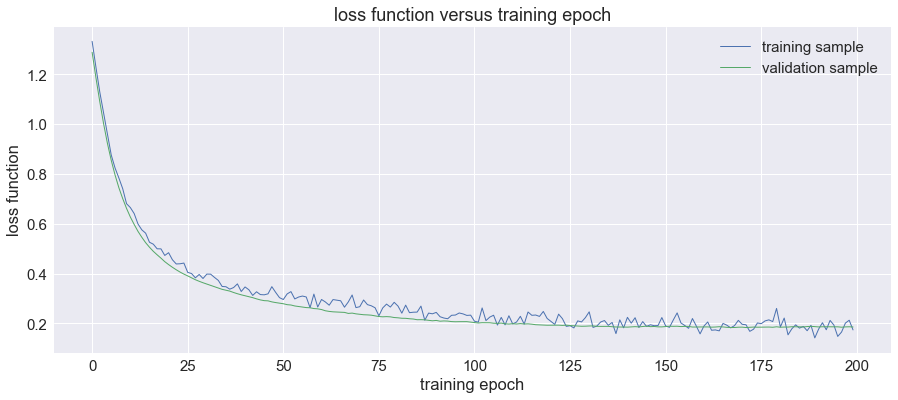

In [165]:
#plot loss vs training epoch
fig, ax = plt.subplots(1,1, figsize=(15, 6))
xp = fit_history.epoch
yp = fit_history.history['loss']
ax.plot(xp, yp, linewidth=1, label='training sample')
yp = fit_history.history['val_loss']
ax.plot(xp, yp, linewidth=1, label='validation sample')
ax.set_title('loss function versus training epoch')
ax.set_ylabel('loss function')
ax.set_xlabel('training epoch')
ax.legend()

In [166]:
#generate dataframe of yields, probabilities, and net 
cols = ['yield'+str(idx) for idx in range(N_buckets)]
import pandas as pd
xy = pd.DataFrame(x_test, columns=cols)
xy['net'] = 0.0
y_test_pred = model.predict(x_test)
for idx in range(N_buckets):
    prob_col = 'prob'+str(idx)
    xy[prob_col] = y_test_pred[:, idx]
    yield_col = 'yield'+str(idx)
    xy['net'] += xy[yield_col]*xy[prob_col]
xy.head()

,yield0,yield1,yield2,yield3,yield4,net,prob0,prob1,prob2,prob3,prob4
0,0.0,0.002822,0.092226,0.689767,1.023822,1.023124,1.537757e-05,1.679686e-05,0.000046,1.862321e-03,0.998059
1,0.0,-0.142307,-0.001064,-0.530162,1.046245,1.046229,1.883889e-09,3.107015e-07,0.000015,1.548409e-10,0.999985
2,0.0,-0.199721,0.633108,0.125224,1.215988,1.215678,2.830524e-08,1.301918e-07,0.000532,8.619202e-09,0.999468
3,0.0,-0.284508,0.487545,0.360485,0.678796,0.675043,2.828330e-05,2.830756e-05,0.018997,2.296938e-04,0.980717
4,0.0,0.426299,-0.169299,0.145414,0.928572,0.927278,2.442483e-05,2.328251e-03,0.000085,1.140995e-05,0.997551


In [ ]:
##show that the predicted value=mean of actuals
#agg_dict = {'y_test':['count', 'mean', 'std'], 'y_test_pred':['mean']}
#test_grouped = test.groupby(cols, as_index=False).agg(agg_dict)
#test_grouped

In [ ]:
##plot y_test_pred vs p0
#df = test_grouped
#xp = df['y_test']['mean']
#yp = df['y_test_pred']['mean']
#fig, ax = plt.subplots(1,1, figsize=(15, 6))
#p = ax.plot(xp, yp, marker='o', markersize=5, linewidth=1, label='y_test_pred')
#p = ax.plot(p0, p0, linewidth=1, label='p0')
#p = ax.set_ylabel('y_test_pred')
#p = ax.set_xlabel('y_test')
#p = ax.legend()